For a give set of edges: 
- load edges file
- construct network
- do a bunch of excercises and calculations: 
    - cliques 



In [1]:
import pandas as pd
import networkx as nx
from networkx import centrality
from networkx.algorithms import clique
from networkx.algorithms import core
from networkx.algorithms import traversal

In [2]:
# filename  = 'edges/example1.txt'
# filename = 'edges/week5_kcore.txt'
# filename = 'edges/at2_q1.txt'
filename = 'edges/edge_betweeness_flow.txt'

df_edges = pd.read_csv(filename, sep=':', header=None, names=['from', 'to_list'])
df_edges['to_list_split'] = df_edges.to_list.str.strip().str.split(',')
df_edges = df_edges.explode('to_list_split')
df_edges['from'] = df_edges['from'].astype(str)
# keep hold of nodes with no edges 
add_nodes = df_edges['from'][df_edges.to_list_split.isna()]
# drop incomplete edges 
df_edges.drop(list(add_nodes.index), inplace=True)
# list(df_edges[['from','to_list_split']].itertuples(index=False))
# [tuple(e) for i,e in df_edges[['from','to_list_split']].iterrows()]
# list(zip(df_edges['from'], df_edges['to_list_split']))
edges = [tuple(e) for e in df_edges[['from','to_list_split']].to_records(index=False)]

In [3]:
set(df_edges['to_list_split'].astype(df_edges['from'].dtype))

{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I'}

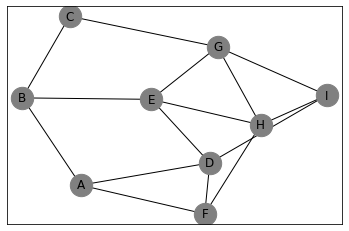

In [4]:
G = nx.Graph()
G.add_edges_from(edges)
G.add_nodes_from(add_nodes)

pos = nx.layout.spring_layout(G)
nx.draw_networkx(G, pos=pos, node_size=500, node_color='grey')

In [5]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 9
Number of edges: 15
Average degree:   3.3333


In [6]:
def get_df(measure, column_name):
    return pd.DataFrame(dict(measure).items(), columns=['node', column_name])

def add_measure(df, measure,column_name): 
    temp = df.join(get_df(measure,column_name),lsuffix='',rsuffix='_r')
    return temp.drop(columns=temp.columns[temp.columns.str.endswith('_r')])

In [7]:
df_measures = pd.DataFrame(list(G.nodes()), columns=['node'])
df_measures

,node
0,A
1,B
2,D
3,F
4,C
5,E
6,I
7,H
8,G


# add measures 

* clustering coefficient 
* degree
* degree centrality 
* closenness cenrality 
* betweenness cenrality 

In [8]:
df_measures = add_measure(df_measures, nx.clustering(G), 'clustring')
df_measures = add_measure(df_measures, nx.degree(G), 'degree')
df_measures = add_measure(df_measures, centrality.degree_centrality(G), 'degree_centrality')
df_measures = add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')
df_measures['closeness_inv'] = 1/df_measures['closeness_centrality']
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=False), 'betweenness')
df_measures = add_measure(df_measures, centrality.betweenness_centrality(G, normalized=True), 'betweenness_centrality')
df_measures = add_measure(df_measures, core.core_number(G), 'core')


In [9]:
add_measure(df_measures, centrality.closeness_centrality(G), 'closeness_centrality')

,node,clustring,degree,degree_centrality,closeness_centrality,closeness_inv,betweenness,betweenness_centrality,core
0,A,0.333333,3,0.375,0.571429,1.750,2.450000,0.087500,2
1,B,0.000000,3,0.375,0.571429,1.750,3.400000,0.121429,2
2,D,0.166667,4,0.500,0.615385,1.625,3.633333,0.129762,2
3,F,0.333333,3,0.375,0.571429,1.750,1.533333,0.054762,2
4,C,0.000000,2,0.250,0.500000,2.000,0.900000,0.032143,2
5,E,0.166667,4,0.500,0.666667,1.500,4.333333,0.154762,2
6,I,0.333333,3,0.375,0.571429,1.750,1.283333,0.045833,2
7,H,0.333333,4,0.500,0.666667,1.500,3.233333,0.115476,2
8,G,0.333333,4,0.500,0.615385,1.625,4.233333,0.151190,2


The core number of a node is the largest value k of a k-core containing that node.

# find all cliques and maximal cliques 

In [10]:

maximal_cliques = [''.join(sorted(c)) for c in clique.find_cliques(G)]
print('maximal cliques')
print(maximal_cliques)

maximal cliques
['AB', 'BE', 'BC', 'ADF', 'DI', 'DE', 'CG', 'GHI', 'EGH', 'FH']


In [11]:
df_cliques = pd.DataFrame([(len(c), sorted(c), ''.join(sorted(c))) for c in clique.enumerate_all_cliques(G) if len(c) > 2], columns=['clique_size', 'clique_list', 'clique'])
df_cliques['maximal_clique'] = df_cliques.clique.isin(maximal_cliques)
df_cliques.query( "maximal_clique == True")

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, D, F]",ADF,True
1,3,"[E, G, H]",EGH,True
2,3,"[G, H, I]",GHI,True


In [12]:
df_cliques.query('clique_size == 3')

,clique_size,clique_list,clique,maximal_clique
0,3,"[A, D, F]",ADF,True
1,3,"[E, G, H]",EGH,True
2,3,"[G, H, I]",GHI,True


# k-core

In [13]:
print('maximal k-core with k = ', max(df_measures.core), ': ', ''.join(sorted([k for k in core.k_core(G)])))

maximal k-core with k =  2 :  ABCDEFGHI


In [14]:
k = 2
''.join(sorted(df_measures.query(f'core >= {k}')['node']))

'ABCDEFGHI'

In [15]:
[c for c in nx.isolates(G)]

[]

# network traversal: BFS and DFS

In [16]:
start_node = 'A'

In [17]:
print(f'BFS traversal start at {start_node}: ', ' '.join([b for b in traversal.bfs_tree(G, start_node)]))

BFS traversal start at A:  A B D F C E I H G


In [18]:
print(f'DFS traversal start at {start_node}: ', ' '.join([b for b in traversal.dfs_tree(G, start_node)]))

DFS traversal start at A:  A B C G E D F H I


Edge Betweenness 

In [20]:
[e for e in traversal.edge_bfs(G, 'A')]

[('A', 'B'),
 ('A', 'D'),
 ('A', 'F'),
 ('B', 'C'),
 ('B', 'E'),
 ('D', 'F'),
 ('D', 'E'),
 ('D', 'I'),
 ('F', 'H'),
 ('C', 'G'),
 ('E', 'G'),
 ('E', 'H'),
 ('I', 'H'),
 ('I', 'G'),
 ('H', 'G')]